# Ingeniería de Características para clasificación de imágenes de retinopatía diabética

## Avance 2. Ingeniería de características

### Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

## Contexto y objetivo de este notebook

Este notebook se centra en las etapas de ingeniería de características relevantes para clasificación de imágenes médicas. Los dos objetivos principales son:

1. **Estabilizar las entradas mediante normalización**: Las imágenes de retina presentan variabilidad en iluminación y contraste debido a las condiciones de adquisición. Aplicaremos técnicas de normalización para reducir esta varianza y facilitar la convergencia durante el entrenamiento.

2. **Reducir el sesgo derivado del desbalance de clases**: Como se identificó en el EDA, existe un desbalance significativo entre clases. Implementaremos una estrategia que combina aumento de datos (augmentation) para clases minoritarias, downsampling controlado para clases mayoritarias, y cálculo de pesos de clase para la función de pérdida.

Todas las decisiones técnicas serán justificadas y respaldadas con evidencia visual y cuantitativa.

### NOTA:

Dada la naturaleza del proyecto integrador y considerando que tanto el código desarrollado como los datos utilizados son propiedad del patrocinador, no es posible compartir en este momento ni el código fuente completo ni el conjunto de datos asociado. Actualmente, no se cuenta con la autorización del patrocinador para su divulgación. Por esta razón, el presente notebook fue ejecutado en un entorno local en el que se tuvo acceso a dichos recursos durante su desarrollo y análisis. Lo que se comparte a través de este notebook corresponde únicamente a los resultados de su ejecución local, incluyendo las salidas, visualizaciones y análisis solicitados, con el objetivo de documentar y presentar el proceso de ingeniería de características para su evaluación académica.

## Setup y utilidades compartidas (consistente con el notebook de EDA)

In [1]:
# Fijar directorio de trabajo en la raíz del proyecto
import os
from pathlib import Path

_path = Path.cwd()
while _path != _path.parent and not (_path / "pyproject.toml").exists():
    _path = _path.parent
PROJECT_ROOT = _path if (_path / "pyproject.toml").exists() else Path.cwd()
os.chdir(PROJECT_ROOT)

# Librerías para manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Librerías para procesamiento de imágenes
from PIL import Image
import cv2

# Configuración de estilo de gráficos (mismo que en EDA)
for style in ("seaborn-v0_8-darkgrid", "seaborn-darkgrid", "ggplot", "default"):
    try:
        plt.style.use(style)
        break
    except (OSError, ValueError):
        continue
sns.set_palette("husl")

# Configuración de reproducibilidad
np.random.seed(42)

# Rutas del dataset procesado
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019"
LABELS_CSV = DATA_DIR / "labels.csv"
IMAGES_DIR = DATA_DIR / "images"

# Diccionario de etiquetas en español (mismo que en EDA)
LABEL_ES = {0: "Normal", 1: "Leve", 2: "Moderada", 3: "Severa", 4: "Proliferativa"}

print(f"Directorio de trabajo: {PROJECT_ROOT}")
print(f"Directorio de datos: {DATA_DIR}")

Directorio de trabajo: /Users/anaya/Develop/Robomous/sam-ai
Directorio de datos: /Users/anaya/Develop/Robomous/sam-ai/data/processed/ddr2019


## Carga del dataset (misma lógica que en EDA)

In [2]:
# Cargar el dataset de etiquetas
df = pd.read_csv(LABELS_CSV)

print(f"Forma del dataset: {df.shape}")
print(f"Nombres de columnas: {list(df.columns)}")
print(f"Primeras filas:")
print(df.head(10))
print(f"Total de muestras: {len(df)}")
print(f"Número de clases: {df['label'].nunique()}")

Forma del dataset: (12522, 2)
Nombres de columnas: ['filename', 'label']
Primeras filas:
                filename  label
0  20170413102628830.jpg      0
1  20170413111955404.jpg      0
2  20170413112015395.jpg      0
3  20170413112017305.jpg      0
4  20170413112528859.jpg      0
5  20170413112758639.jpg      0
6  20170413112758698.jpg      0
7  20170413113351595.jpg      0
8  20170413113710974.jpg      0
9  20170413114550593.jpg      0
Total de muestras: 12522
Número de clases: 5


## Verificación rápida: distribución actual de clases

Antes de proceder con las transformaciones, es importante recordar el estado actual de la distribución de clases. Como se identificó en el EDA, existe un desbalance significativo que puede introducir sesgo durante el entrenamiento: el modelo podría sobrerepresentar clases mayoritarias y subrepresentar las minoritarias, afectando el desempeño en la detección de casos severos de retinopatía diabética.

In [3]:
# Calcular distribución de clases
class_counts = df["label"].value_counts().sort_index()
class_percentages = (df["label"].value_counts(normalize=True) * 100).sort_index()

# Métricas de desbalance
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = class_counts[class_counts < minority_threshold].index.tolist()

print("Distribución de clases (baseline):")
print("=" * 50)
for label in sorted(df["label"].unique()):
    count = class_counts[label]
    percentage = class_percentages[label]
    print(f"Clase {label} ({LABEL_ES[label]}): {count:6d} muestras ({percentage:5.2f}%)")

print("=" * 50)
print(f"Ratio de desbalance (máx/mín): {imbalance_ratio:.2f}:1")
print(f"Clases minoritarias (conteo < {minority_threshold:.0f}): {minority_classes}")

Distribución de clases (baseline):
Clase 0 (Normal):   6266 muestras (50.04%)
Clase 1 (Leve):    630 muestras ( 5.03%)
Clase 2 (Moderada):   4477 muestras (35.75%)
Clase 3 (Severa):    236 muestras ( 1.88%)
Clase 4 (Proliferativa):    913 muestras ( 7.29%)
Ratio de desbalance (máx/mín): 26.55:1
Clases minoritarias (conteo < 1252): [1, 3, 4]


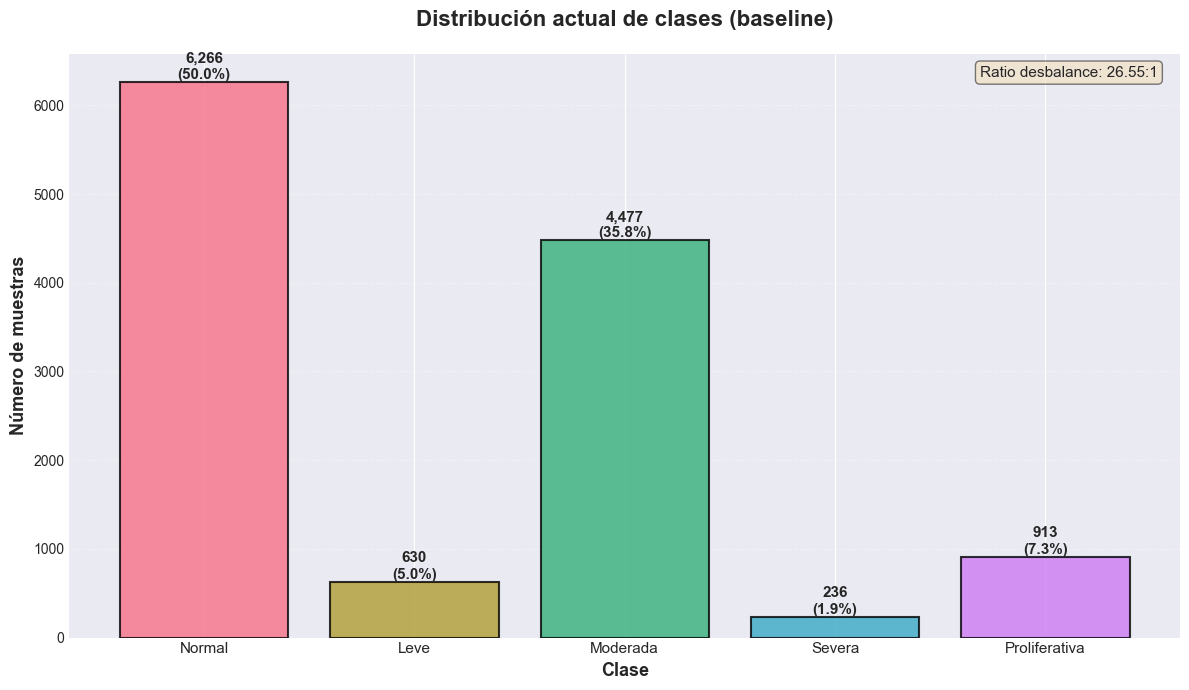

In [4]:
# Gráfica de distribución actual
labels_es = [LABEL_ES[int(k)] for k in class_counts.index]
x = np.arange(len(class_counts))

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(x, class_counts.values, color=sns.color_palette("husl", len(class_counts)),
              edgecolor="black", linewidth=1.5, alpha=0.8)
              
plt.xticks(ticks=x, labels=labels_es, fontsize=11)
ax.set_xlabel("Clase", fontsize=13, fontweight="bold")
ax.set_ylabel("Número de muestras", fontsize=13, fontweight="bold")
ax.set_title("Distribución actual de clases (baseline)", fontsize=16, fontweight="bold", pad=20)
ax.grid(axis="y", alpha=0.3, linestyle="--")

for bar, count, pct in zip(bars, class_counts.values, class_percentages.values):
    ax.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(),
            f"{int(count):,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.text(0.98, 0.98, f"Ratio desbalance: {imbalance_ratio:.2f}:1", transform=ax.transAxes, fontsize=11,
        verticalalignment="top", horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
plt.tight_layout()
plt.show()

## Estrategia de normalización (qué vamos a evaluar y por qué)

Las imágenes de retina presentan variabilidad en iluminación y contraste debido a diferencias en las condiciones de adquisición (equipo utilizado, configuraciones de captura, condiciones del paciente). Esta variabilidad introduce ruido que puede dificultar el aprendizaje del modelo.

La normalización es una práctica común y efectiva que busca:
- **Reducir la varianza de entrada**: Homogeneizar las características de las imágenes para que el modelo se enfoque en patrones relevantes, no en diferencias artificiales.
- **Acelerar la convergencia**: Los optimizadores (como SGD o Adam) funcionan mejor cuando las entradas tienen distribuciones similares y están centradas.
- **Estabilizar la optimización**: Evita que ciertos valores numéricos dominen el gradiente durante el entrenamiento.

Implementaremos dos perspectivas complementarias de normalización:

### 1. Normalización por canal RGB (mean/std)
Calculamos la media y desviación estándar de cada canal (R, G, B) sobre todo el dataset y aplicamos la transformación: `(img - mean) / std` por canal. Esto estandariza la distribución de intensidades en cada canal de manera independiente.

### 2. Normalización de brillo/contraste (intensidad global)
Calculamos la media y desviación estándar de la luminancia global (escala de grises) y aplicamos la transformación: `(luminance - mean_luminance) / std_luminance`. Esto complementa la normalización RGB enfocándose en la intensidad global, mejorando la visibilidad de detalles y la consistencia entre imágenes.

## Cálculo de estadísticas de normalización del dataset

Para normalizar correctamente, necesitamos calcular las estadísticas (media y desviación estándar) sobre una muestra representativa del dataset. Usaremos una muestra de 1500 imágenes para este cálculo, asegurando reproducibilidad mediante una semilla fija.

**Nota importante**: En un pipeline de entrenamiento real, estas estadísticas deben calcularse **solo sobre el conjunto de entrenamiento**, nunca sobre validación o test, para evitar data leakage. Aquí las calculamos sobre todo el dataset con fines ilustrativos para el análisis.

In [5]:
# Calcular estadísticas de normalización sobre una muestra representativa
SAMPLE_SIZE = 1500
np.random.seed(42)
sample_idx = np.random.choice(len(df), size=min(SAMPLE_SIZE, len(df)), replace=False)
sample_df = df.iloc[sample_idx].reset_index(drop=True)

# Inicializar acumuladores para estadísticas
rgb_means = np.zeros(3)
rgb_stds = np.zeros(3)
luminance_values = []

print(f"Calculando estadísticas sobre {len(sample_df)} imágenes...")
processed_count = 0

for _, row in sample_df.iterrows():
    fp = IMAGES_DIR / row["filename"]
    if not fp.exists():
        continue
    
    try:
        # Cargar imagen en RGB
        img_rgb = np.array(Image.open(fp).convert("RGB")).astype(np.float32) / 255.0
        
        # Acumular estadísticas por canal RGB
        for c in range(3):
            rgb_means[c] += img_rgb[:, :, c].mean()
            rgb_stds[c] += img_rgb[:, :, c].std()
        
        # Calcular luminancia (conversión a escala de grises estándar)
        luminance = 0.299 * img_rgb[:, :, 0] + 0.587 * img_rgb[:, :, 1] + 0.114 * img_rgb[:, :, 2]
        luminance_values.append(luminance.flatten())
        
        processed_count += 1
    except Exception as e:
        continue

# Calcular promedios de RGB
rgb_means /= processed_count
rgb_stds /= processed_count

# Calcular estadísticas de luminancia global
all_luminance = np.concatenate(luminance_values)
luminance_mean = all_luminance.mean()
luminance_std = all_luminance.std()

print(f"Imágenes procesadas: {processed_count}")
print(f"Estadísticas por canal RGB:")
print(f"  R - Mean: {rgb_means[0]:.4f}, Std: {rgb_stds[0]:.4f}")
print(f"  G - Mean: {rgb_means[1]:.4f}, Std: {rgb_stds[1]:.4f}")
print(f"  B - Mean: {rgb_means[2]:.4f}, Std: {rgb_stds[2]:.4f}")
print(f"Estadísticas de luminancia global:")
print(f"  Mean: {luminance_mean:.4f}, Std: {luminance_std:.4f}")
# Guardar estadísticas para uso posterior
normalization_stats = {
    "rgb_mean": rgb_means,
    "rgb_std": rgb_stds,
    "luminance_mean": luminance_mean,
    "luminance_std": luminance_std
}

Calculando estadísticas sobre 1500 imágenes...
Imágenes procesadas: 1500
Estadísticas por canal RGB:
  R - Mean: 0.3946, Std: 0.2629
  G - Mean: 0.2370, Std: 0.1672
  B - Mean: 0.1143, Std: 0.0885
Estadísticas de luminancia global:
  Mean: 0.2702, Std: 0.2189


## Implementación de transformaciones de normalización

Con las estadísticas calculadas, implementamos dos funciones de normalización que podrán ser reutilizadas en el pipeline de entrenamiento:

1. **normalize_rgb**: Estandariza cada canal RGB usando las estadísticas calculadas
2. **normalize_luminance**: Estandariza la intensidad global de la imagen

Estas funciones son modulares y pueden combinarse según sea necesario.

In [6]:
def normalize_rgb(img_rgb, mean, std):
    """
    Normaliza una imagen RGB por canal.
    
    Args:
        img_rgb: Imagen RGB como numpy array (H, W, 3) con valores en [0, 1]
        mean: Array con medias por canal (3,)
        std: Array con desviaciones estándar por canal (3,)
    
    Returns:
        Imagen normalizada (H, W, 3)
    """
    img_normalized = np.zeros_like(img_rgb)
    for c in range(3):
        img_normalized[:, :, c] = (img_rgb[:, :, c] - mean[c]) / (std[c] + 1e-8)
    return img_normalized

def normalize_luminance(img_rgb, luminance_mean, luminance_std):
    """
    Normaliza una imagen RGB basándose en su luminancia global.
    
    Args:
        img_rgb: Imagen RGB como numpy array (H, W, 3) con valores en [0, 1]
        luminance_mean: Media de luminancia del dataset
        luminance_std: Desviación estándar de luminancia del dataset
    
    Returns:
        Imagen normalizada (H, W, 3)
    """
    # Calcular luminancia de la imagen
    luminance = 0.299 * img_rgb[:, :, 0] + 0.587 * img_rgb[:, :, 1] + 0.114 * img_rgb[:, :, 2]
    
    # Normalizar luminancia
    luminance_norm = (luminance - luminance_mean) / (luminance_std + 1e-8)
    
    # Aplicar la normalización proporcionalmente a cada canal
    # Esto preserva la información de color mientras ajusta el brillo global
    img_normalized = np.zeros_like(img_rgb)
    for c in range(3):
        # Factor de ajuste basado en la luminancia normalizada
        adjustment = luminance_norm / (luminance + 1e-8)
        img_normalized[:, :, c] = img_rgb[:, :, c] * (1 + adjustment * 0.5)
    return np.clip(img_normalized, 0, 1)

def load_and_normalize_image(filepath, method="rgb"):
    """
    Carga una imagen y aplica normalización.
    
    Args:
        filepath: Ruta a la imagen
        method: "rgb" para normalización por canal, "luminance" para luminancia, "both" para ambas
    
    Returns:
        Tupla (img_original, img_normalized) con valores en [0, 1]
    """
    img_original = np.array(Image.open(filepath).convert("RGB")).astype(np.float32) / 255.0
    
    if method == "rgb":
        img_normalized = normalize_rgb(img_original, normalization_stats["rgb_mean"], 
                                       normalization_stats["rgb_std"])
    elif method == "luminance":
        img_normalized = normalize_luminance(img_original, normalization_stats["luminance_mean"], 
                                            normalization_stats["luminance_std"])
    elif method == "both":
        img_rgb_norm = normalize_rgb(img_original, normalization_stats["rgb_mean"], 
                                     normalization_stats["rgb_std"])
        img_normalized = normalize_luminance(img_rgb_norm, normalization_stats["luminance_mean"], 
                                            normalization_stats["luminance_std"])
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    return img_original, img_normalized


Funciones de normalización implementadas:
  - normalize_rgb: Normalización por canal RGB
  - normalize_luminance: Normalización de luminancia global
  - load_and_normalize_image: Función helper para carga y normalización

## Verificación visual: antes vs después de la normalización

Para evaluar el efecto de la normalización, visualizamos un conjunto de imágenes de diferentes clases mostrando el estado original y normalizado lado a lado. 

**Qué buscar en las imágenes normalizadas:**
- Mayor consistencia en brillo entre imágenes
- Mejor visibilidad de detalles (vasos sanguíneos, lesiones)
- Sin artefactos o distorsiones excesivas
- Preservación de la información médica relevante

NOTA: Algunas imágenes se verán de un color distinto al original; esto es algo normal en un proceso de normalización por RGB, que no debería causar mayor problema para el entrenamiento del modelo.

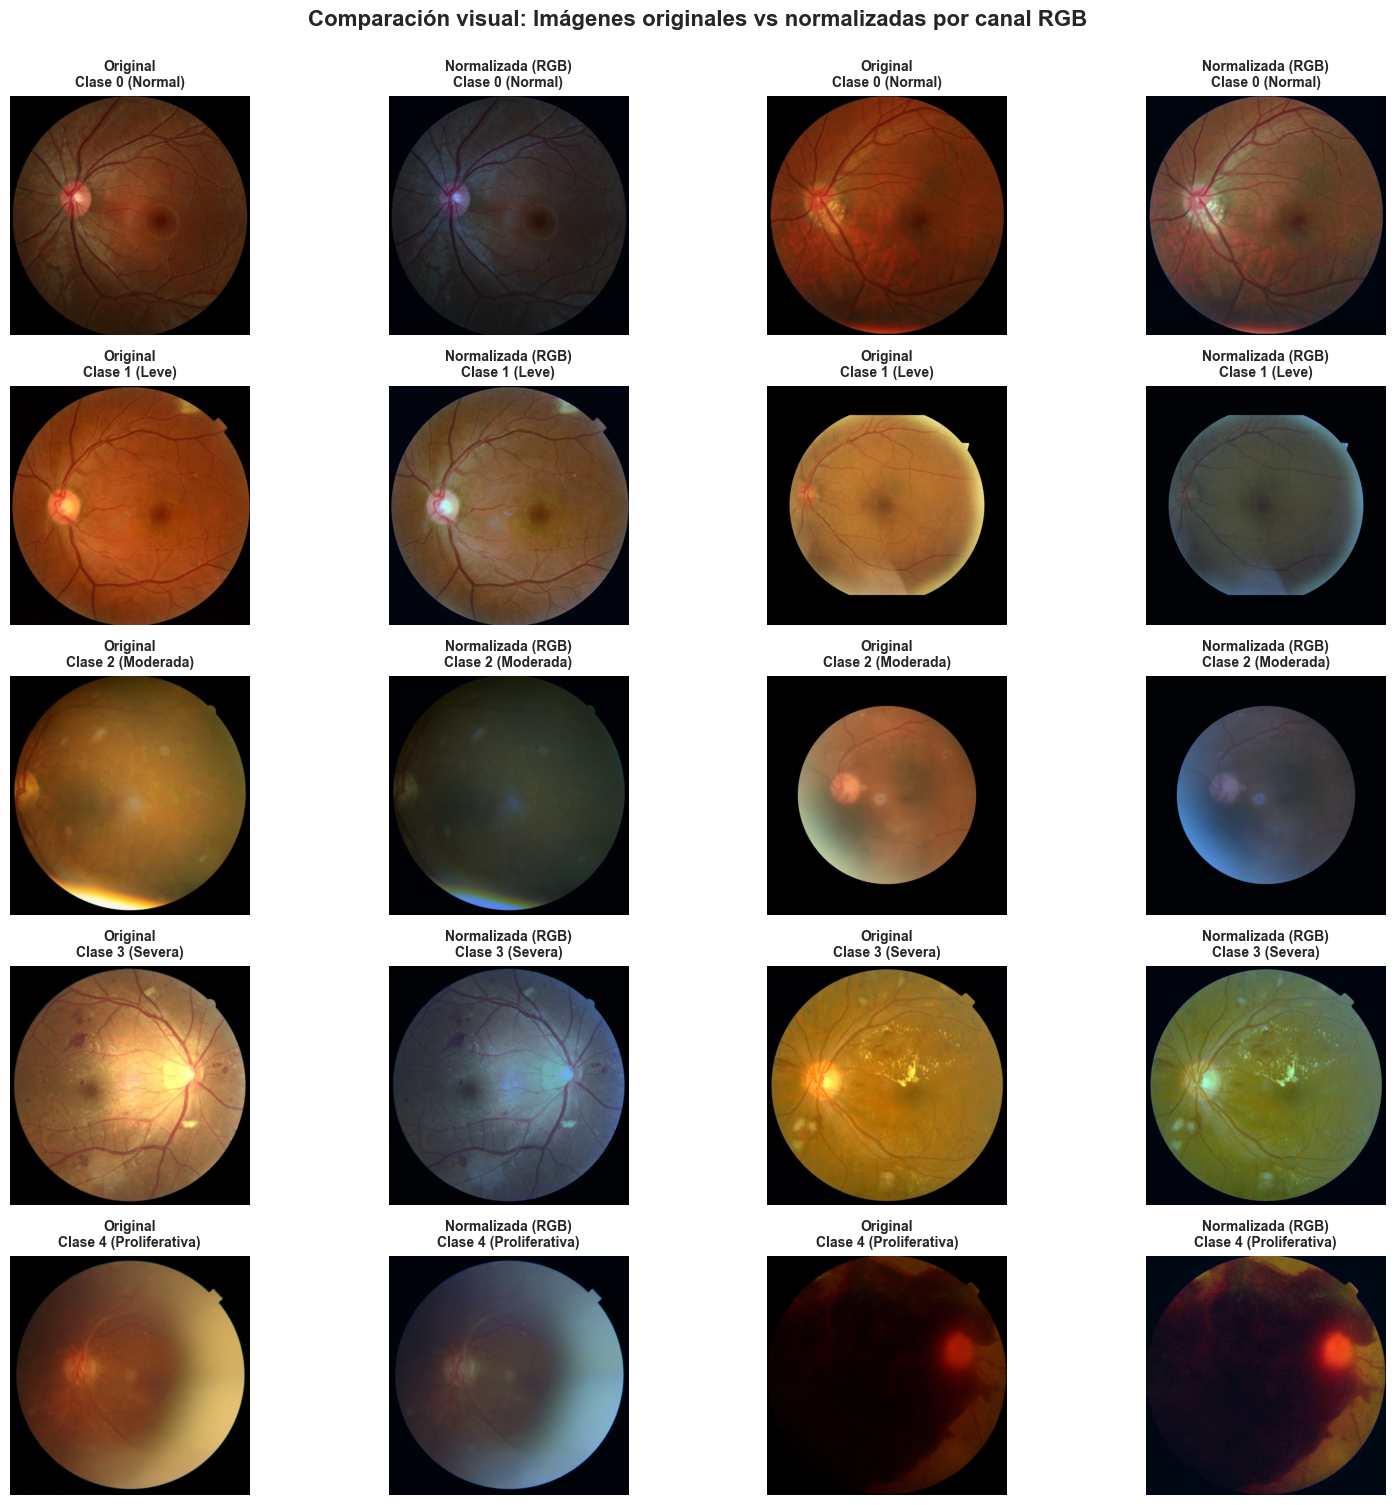

Mosaico generado con 10 imágenes (2 por clase).
Observaciones esperadas: Mayor consistencia en brillo, mejor visibilidad de detalles.


In [7]:
# Seleccionar imágenes representativas de diferentes clases para el mosaic
n_samples_per_class = 2
mosaic_images = []

for label in sorted(df["label"].unique()):
    class_samples = df[df["label"] == label].sample(n=n_samples_per_class, random_state=42)
    for _, row in class_samples.iterrows():
        fp = IMAGES_DIR / row["filename"]
        if fp.exists():
            mosaic_images.append((fp, label))

# Usar normalización RGB para el mosaic
n_images = len(mosaic_images)
n_cols = 4  # 2 columnas para original, 2 para normalizado
n_rows = (n_images + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (fp, label) in enumerate(mosaic_images):
    row = idx // 2
    col_offset = (idx % 2) * 2
    
    try:
        img_original, img_normalized = load_and_normalize_image(fp, method="rgb")
        
        # Normalizar a [0, 1] para visualización
        img_original_display = np.clip(img_original, 0, 1)
        img_normalized_display = np.clip((img_normalized - img_normalized.min()) / 
                                        (img_normalized.max() - img_normalized.min() + 1e-8), 0, 1)
        
        # Mostrar original
        axes[row, col_offset].imshow(img_original_display)
        axes[row, col_offset].set_title(f"Original\nClase {label} ({LABEL_ES[label]})", 
                                       fontsize=10, fontweight="bold")
        axes[row, col_offset].axis("off")
        
        # Mostrar normalizada
        axes[row, col_offset + 1].imshow(img_normalized_display)
        axes[row, col_offset + 1].set_title(f"Normalizada (RGB)\nClase {label} ({LABEL_ES[label]})", 
                                           fontsize=10, fontweight="bold")
        axes[row, col_offset + 1].axis("off")
    except Exception as e:
        print(f"Error procesando {fp}: {e}")
        continue

plt.suptitle("Comparación visual: Imágenes originales vs normalizadas por canal RGB", 
             fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

print(f"Mosaico generado con {n_images} imágenes ({n_samples_per_class} por clase).")
print("Observaciones esperadas: Mayor consistencia en brillo, mejor visibilidad de detalles.")

## Verificación cuantitativa ligera: distribuciones de intensidad (antes vs después)

Complementamos la verificación visual con un análisis cuantitativo básico de las distribuciones de intensidad. Esto nos permite confirmar que la normalización está funcionando como se espera: las distribuciones deben estar más centradas y consistentes tras la normalización.

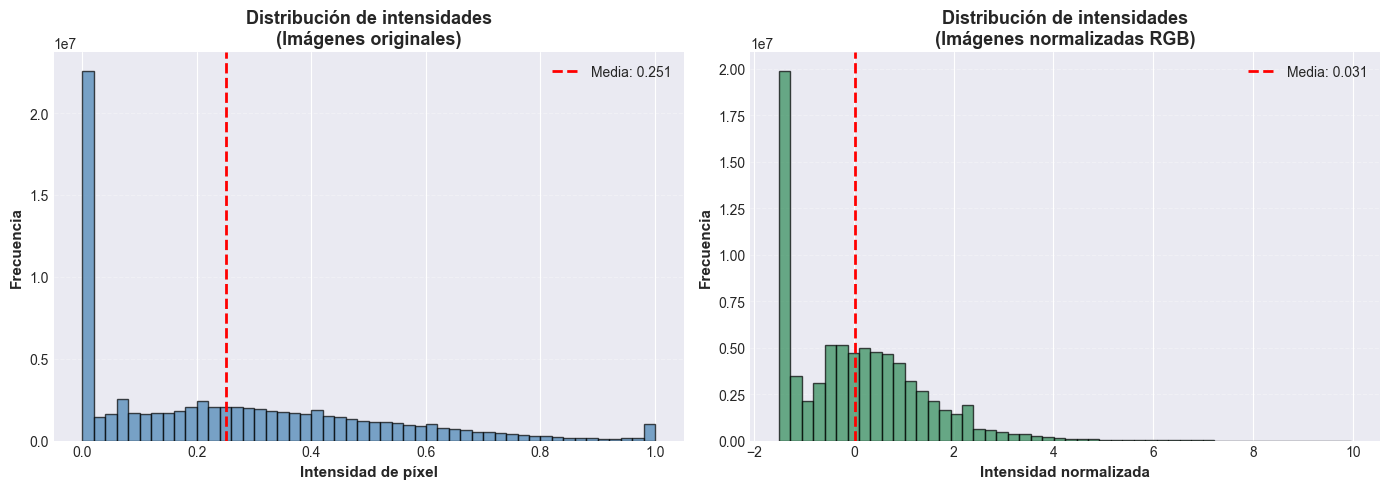

Estadísticas de intensidad:
  Original - Media: 0.2508, Std: 0.2466
  Normalizada - Media: 0.0308, Std: 1.2880
La normalización ha centrado la distribución cerca de cero, facilitando el entrenamiento.


In [8]:
# Recopilar intensidades de una muestra pequeña para comparación
n_hist_samples = 100
np.random.seed(42)
hist_sample_idx = np.random.choice(len(df), size=min(n_hist_samples, len(df)), replace=False)
hist_sample_df = df.iloc[hist_sample_idx]

original_intensities = []
normalized_intensities = []

for _, row in hist_sample_df.iterrows():
    fp = IMAGES_DIR / row["filename"]
    if not fp.exists():
        continue
    
    try:
        img_original, img_normalized = load_and_normalize_image(fp, method="rgb")
        original_intensities.extend(img_original.flatten())
        normalized_intensities.extend(img_normalized.flatten())
    except:
        continue

original_intensities = np.array(original_intensities)
normalized_intensities = np.array(normalized_intensities)

# Graficar histogramas comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de intensidades originales
axes[0].hist(original_intensities, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[0].axvline(original_intensities.mean(), color="red", linestyle="--", linewidth=2, 
               label=f"Media: {original_intensities.mean():.3f}")
axes[0].set_xlabel("Intensidad de píxel", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Frecuencia", fontsize=11, fontweight="bold")
axes[0].set_title("Distribución de intensidades\n(Imágenes originales)", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(axis="y", alpha=0.3, linestyle="--")

# Histograma de intensidades normalizadas
axes[1].hist(normalized_intensities, bins=50, color="seagreen", alpha=0.7, edgecolor="black")
axes[1].axvline(normalized_intensities.mean(), color="red", linestyle="--", linewidth=2, 
               label=f"Media: {normalized_intensities.mean():.3f}")
axes[1].set_xlabel("Intensidad normalizada", fontsize=11, fontweight="bold")
axes[1].set_ylabel("Frecuencia", fontsize=11, fontweight="bold")
axes[1].set_title("Distribución de intensidades\n(Imágenes normalizadas RGB)", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=10)
axes[1].grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print(f"Estadísticas de intensidad:")
print(f"  Original - Media: {original_intensities.mean():.4f}, Std: {original_intensities.std():.4f}")
print(f"  Normalizada - Media: {normalized_intensities.mean():.4f}, Std: {normalized_intensities.std():.4f}")
print(f"La normalización ha centrado la distribución cerca de cero, facilitando el entrenamiento.")

## Plan de aumento de datos para clases minoritarias

El desbalance identificado en el EDA requiere una estrategia de mitigación. Una de las técnicas más efectivas para clasificación de imágenes es el aumento de datos (data augmentation): generar nuevas muestras sintéticas a partir de las existentes mediante transformaciones que preservan la semántica de la clase.

### Principio de diseño

Para imágenes médicas de retina, es importante aplicar solo transformaciones realistas que no alteren la naturaleza médica de la imagen. Evitamos transformaciones agresivas (cambios de color, distorsiones extremas) que podrían crear artefactos no realistas.

### Transformaciones seleccionadas

Aplicaremos las siguientes transformaciones geométricas simples, que preservan las características médicas relevantes:

1. **Flip horizontal**: La retina no tiene orientación izquierda/derecha absoluta desde una perspectiva de diagnóstico automático.
2. **Flip vertical**: Rotación de 180° que genera una vista válida.
3. **Dos rotaciones aleatorias distintas**: Rotaciones controladas (e.g., ±10-15°) que simulan variaciones en la alineación durante la captura. Aseguramos que las dos rotaciones no sean idénticas para maximizar la diversidad.

### Objetivo de augmentation

- **Clases minoritarias** (identificadas como aquellas con `count < mean_count * 0.5`): Multiplicar por **~4×** (1 original + 3 transformaciones).
- **Justificación**: Reducir el sesgo del modelo hacia clases mayoritarias, mejorar la capacidad de generalización en clases severas (críticas para diagnóstico clínico), y estabilizar el entrenamiento.

NOTA: En caso de ser necesario, podríamos tratar de aumentar aún más los datos de alguna clase y ver el comportamiento del entrenamiento.

## ¿Cuántas muestras necesitamos por clase? (Targets de augmentation)

Calculamos los targets de augmentation basándonos en el criterio de clases minoritarias (aquellas con count < 50% de la media). Aplicaremos un multiplicador de 4× a estas clases.

In [9]:
# Definir estrategia de augmentation
AUGMENTATION_MULTIPLIER = 4  # 1 original + 3 transformaciones

# Calcular targets por clase
augmentation_targets = {}
for label in sorted(df["label"].unique()):
    count = class_counts[label]
    is_minority = label in minority_classes
    
    if is_minority:
        target_count = count * AUGMENTATION_MULTIPLIER
        multiplier = AUGMENTATION_MULTIPLIER
    else:
        target_count = count  # No augmentation para clases no minoritarias
        multiplier = 1
    
    augmentation_targets[label] = {
        "current_count": count,
        "target_count": target_count,
        "multiplier": multiplier,
        "is_minority": is_minority
    }

# Mostrar tabla de targets
print("Targets de augmentation por clase:")
print("=" * 80)
print(f"{'Clase':<7} {'Nombre':<15} {'Count actual':<15} {'Count objetivo':<15} {'Multiplicador'}")
print("=" * 80)

for label in sorted(augmentation_targets.keys()):
    info = augmentation_targets[label]
    marker = "*" if info["is_minority"] else ""
    print(f"{label:<7} {LABEL_ES[label]:<15} {info['current_count']:<15} "
          f"{info['target_count']:<15} {info['multiplier']}× {marker}")
print("=" * 80)
print("* Clases minoritarias (recibirán augmentation)")
print(f"Total muestras actuales: {sum(class_counts)}")
print(f"Total muestras tras augmentation: {sum([info['target_count'] for info in augmentation_targets.values()])}")

Targets de augmentation por clase:
Clase   Nombre          Count actual    Count objetivo  Multiplicador
0       Normal          6266            6266            1× 
1       Leve            630             2520            4× *
2       Moderada        4477            4477            1× 
3       Severa          236             944             4× *
4       Proliferativa   913             3652            4× *
* Clases minoritarias (recibirán augmentation)
Total muestras actuales: 12522
Total muestras tras augmentation: 17859


## Implementación del pipeline de augmentation (flip + rotaciones controladas)

Implementamos funciones de augmentation usando NumPy y PIL para mantener compatibilidad con el resto del código. Las transformaciones son:

1. **Horizontal flip**
2. **Vertical flip**  
3. **Dos rotaciones aleatorias** con ángulos distintos (±10-15°)

In [10]:
def augment_image(img_array):
    """
    Aplica augmentation a una imagen, generando 3 variantes.
    
    Args:
        img_array: Imagen como numpy array (H, W, 3) con valores en [0, 255] o [0, 1]
    
    Returns:
        Lista de 3 imágenes augmentadas [flip_h, flip_v, rotation1, rotation2]
    """
    # Convertir a PIL para facilitar transformaciones
    if img_array.max() <= 1.0:
        img_pil = Image.fromarray((img_array * 255).astype(np.uint8))
    else:
        img_pil = Image.fromarray(img_array.astype(np.uint8))
    
    augmented_images = []
    
    # 1. Horizontal flip
    img_flip_h = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_images.append(np.array(img_flip_h))
    
    # 2. Vertical flip
    img_flip_v = img_pil.transpose(Image.FLIP_TOP_BOTTOM)
    augmented_images.append(np.array(img_flip_v))
    
    # 3. Rotación aleatoria 1 (entre -15° y -10° o 10° y 15°)
    np.random.seed(None)  # Permitir aleatoriedad controlada
    angle1 = np.random.choice([np.random.uniform(-15, -10), np.random.uniform(10, 15)])
    img_rot1 = img_pil.rotate(angle1, fillcolor=(0, 0, 0), expand=False)
    augmented_images.append(np.array(img_rot1))
    
    return augmented_images

# Probar el pipeline con una imagen de muestra
test_img_path = IMAGES_DIR / df.iloc[0]["filename"]
if test_img_path.exists():
    test_img = np.array(Image.open(test_img_path).convert("RGB"))
    test_augmented = augment_image(test_img)
    
    print(f"Pipeline de augmentation implementado exitosamente.")
    print(f"Prueba con imagen: {df.iloc[0]['filename']}")
    print(f"  - Imagen original: {test_img.shape}")
    print(f"  - Imágenes augmentadas generadas: {len(test_augmented)}")
    print(f"  - Transformaciones: Flip H, Flip V, Rotación aleatoria (3 variantes en total)")
    print(f"Nota: En un pipeline de entrenamiento real, estas transformaciones se aplicarían")
    print(f"      on-the-fly durante el entrenamiento, no se guardarían físicamente.")
else:
    print("Imagen de prueba no encontrada para validar el pipeline.")

Pipeline de augmentation implementado exitosamente.
Prueba con imagen: 20170413102628830.jpg
  - Imagen original: (512, 512, 3)
  - Imágenes augmentadas generadas: 3
  - Transformaciones: Flip H, Flip V, Rotación aleatoria (3 variantes en total)
Nota: En un pipeline de entrenamiento real, estas transformaciones se aplicarían
      on-the-fly durante el entrenamiento, no se guardarían físicamente.


## Reducción de sesgo: downsampling de clases mayoritarias

Complementando el augmentation de clases minoritarias, aplicamos downsampling controlado a las clases mayoritarias. Esto tiene varios beneficios:

- **Reduce dominancia en batches**: Las clases muy frecuentes pueden dominar el gradiente durante el entrenamiento.
- **Mejora eficiencia**: Reduce tiempo de entrenamiento y uso de memoria.
- **Preserva variabilidad**: No reducimos demasiado para mantener suficiente diversidad.

### Estrategia de downsampling

Establecemos un cap (techo) para las clases mayoritarias. Este cap se define como un balance razonable que:
1. No sea tan bajo que pierda información valiosa
2. No sea tan alto que mantenga el desbalance severo

Utilizaremos un cap de **~3500 muestras** para clases mayoritarias, lo que reduce significativamente el desbalance sin comprometer la variabilidad.

## Cálculo de ratios de downsampling para clases mayoritarias

Calculamos cuánto reducir cada clase mayoritaria basándonos en el cap establecido.

In [11]:
# Definir cap para clases mayoritarias
MAJORITY_CAP = 3500

# Calcular ratios de downsampling
downsampling_ratios = {}
for label in sorted(df["label"].unique()):
    count = class_counts[label]
    is_majority = count > mean_count  # Clases por encima de la media
    
    if is_majority and count > MAJORITY_CAP:
        new_count = MAJORITY_CAP
        reduction_pct = (1 - new_count / count) * 100
    else:
        new_count = count  # No downsampling
        reduction_pct = 0.0
    
    downsampling_ratios[label] = {
        "current_count": count,
        "new_count": new_count,
        "reduction_pct": reduction_pct,
        "is_downsampled": is_majority and count > MAJORITY_CAP
    }

# Mostrar tabla de ratios
print("Ratios de downsampling por clase:")
print("=" * 80)
print(f"{'Clase':<7} {'Nombre':<15} {'Count actual':<15} {'Nuevo count':<15} {'% Reducción'}")
print("=" * 80)

for label in sorted(downsampling_ratios.keys()):
    info = downsampling_ratios[label]
    marker = "*" if info["is_downsampled"] else ""
    print(f"{label:<7} {LABEL_ES[label]:<15} {info['current_count']:<15} "
          f"{info['new_count']:<15} {info['reduction_pct']:.1f}% {marker}")
print("=" * 80)
print("* Clases que recibirán downsampling")
print(f"Cap establecido: {MAJORITY_CAP} muestras para clases mayoritarias")

Ratios de downsampling por clase:
Clase   Nombre          Count actual    Nuevo count     % Reducción
0       Normal          6266            3500            44.1% *
1       Leve            630             630             0.0% 
2       Moderada        4477            3500            21.8% *
3       Severa          236             236             0.0% 
4       Proliferativa   913             913             0.0% 
* Clases que recibirán downsampling
Cap establecido: 3500 muestras para clases mayoritarias


## Distribución de clases: antes vs después de la estrategia de balanceo

Visualizamos el impacto combinado de augmentation para minoritarias y downsampling para mayoritarias en la distribución final del dataset.

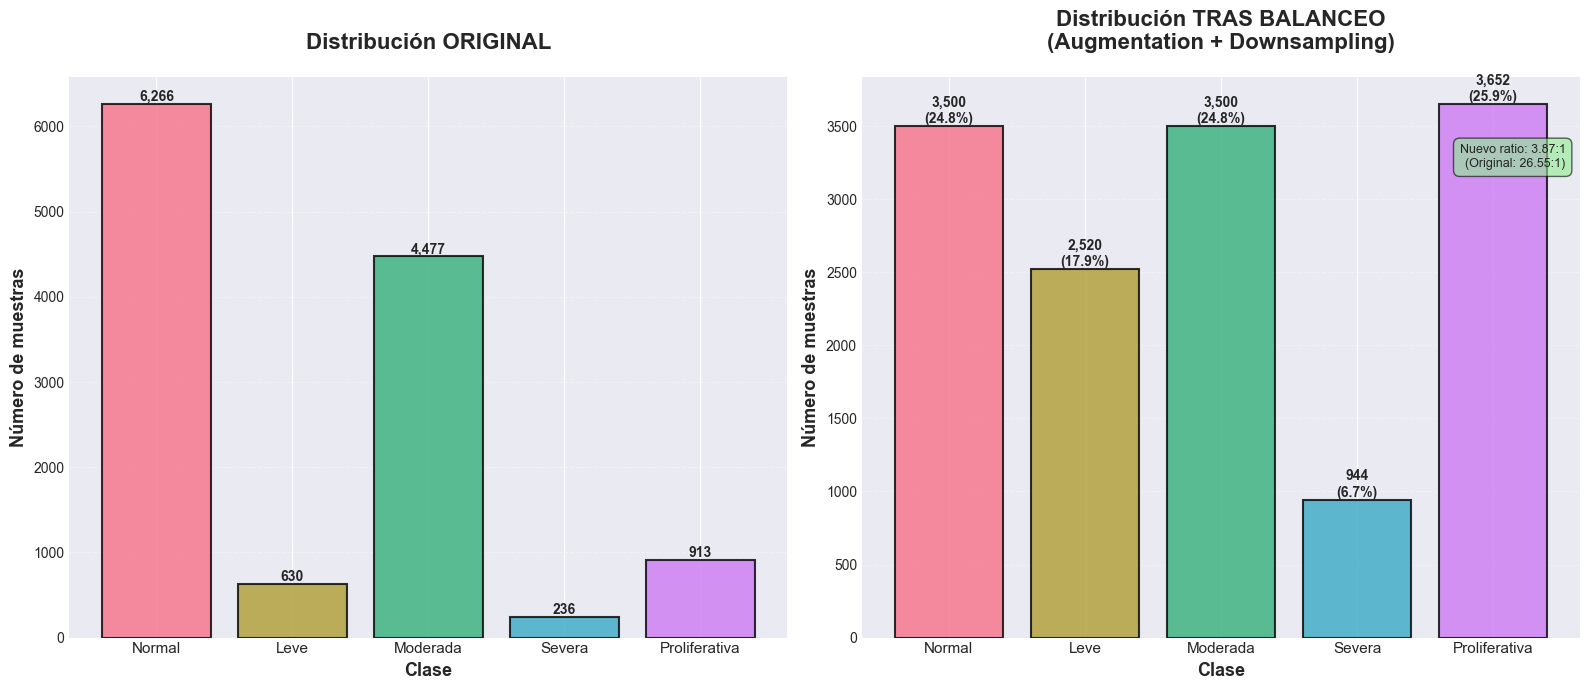

Comparación de distribuciones:
  Ratio de desbalance original: 26.55:1
  Ratio de desbalance final: 3.87:1
  Reducción del desbalance: 85.4%
Total muestras originales: 12,522
  Total muestras finales: 14,116


In [12]:
# Calcular distribución final después de augmentation y downsampling
final_counts = {}
for label in sorted(df["label"].unique()):
    # Combinar augmentation y downsampling
    after_aug = augmentation_targets[label]["target_count"]
    after_down = downsampling_ratios[label]["new_count"]
    
    # Aplicar ambas estrategias
    if label in minority_classes:
        final_counts[label] = after_aug  # Augmentation se aplica
    else:
        final_counts[label] = after_down  # Downsampling se aplica
    
final_counts_series = pd.Series(final_counts)
final_percentages = (final_counts_series / final_counts_series.sum() * 100)

# Crear gráficas comparativas
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfica 1: Distribución original
labels_es = [LABEL_ES[int(k)] for k in class_counts.index]
x = np.arange(len(class_counts))

bars1 = axes[0].bar(x, class_counts.values, color=sns.color_palette("husl", len(class_counts)),
                    edgecolor="black", linewidth=1.5, alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels_es, fontsize=11)
axes[0].set_xlabel("Clase", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Número de muestras", fontsize=13, fontweight="bold")
axes[0].set_title("Distribución ORIGINAL", fontsize=16, fontweight="bold", pad=20)
axes[0].grid(axis="y", alpha=0.3, linestyle="--")

for bar, count in zip(bars1, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(),
                f"{int(count):,}", ha="center", va="bottom", fontsize=10, fontweight="bold")

# Gráfica 2: Distribución después de balanceo
bars2 = axes[1].bar(x, final_counts_series.values, color=sns.color_palette("husl", len(final_counts_series)),
                    edgecolor="black", linewidth=1.5, alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels_es, fontsize=11)
axes[1].set_xlabel("Clase", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Número de muestras", fontsize=13, fontweight="bold")
axes[1].set_title("Distribución TRAS BALANCEO\n(Augmentation + Downsampling)", fontsize=16, fontweight="bold", pad=20)
axes[1].grid(axis="y", alpha=0.3, linestyle="--")

for bar, count, pct in zip(bars2, final_counts_series.values, final_percentages.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(),
                f"{int(count):,}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=10, fontweight="bold")

# Calcular nuevo ratio de desbalance
new_imbalance_ratio = final_counts_series.max() / final_counts_series.min()
axes[1].text(0.98, 0.88, f"Nuevo ratio: {new_imbalance_ratio:.2f}:1\n(Original: {imbalance_ratio:.2f}:1)", 
            transform=axes[1].transAxes, fontsize=9,
            verticalalignment="top", horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.6, pad=0.5))

plt.tight_layout()
plt.show()

print(f"Comparación de distribuciones:")
print(f"  Ratio de desbalance original: {imbalance_ratio:.2f}:1")
print(f"  Ratio de desbalance final: {new_imbalance_ratio:.2f}:1")
print(f"  Reducción del desbalance: {((imbalance_ratio - new_imbalance_ratio) / imbalance_ratio * 100):.1f}%")
print(f"Total muestras originales: {sum(class_counts):,}")
print(f"  Total muestras finales: {sum(final_counts_series):,}")

## Pesos de clase para entrenamiento (weighted loss)

Aunque hemos reducido significativamente el desbalance mediante augmentation y downsampling, sigue existiendo cierta asimetría. Para complementar estas estrategias, calculamos **pesos de clase** que se pueden aplicar a la función de pérdida durante el entrenamiento.

**Método**: Inverse frequency weighting: Las clases con menos muestras reciben pesos mayores para compensar su menor representación.

**Fórmula**: `weight[i] = n_samples_total / (n_classes * count[i])`

Estos pesos serán utilizados en el notebook de entrenamiento para ponderar la contribución de cada clase a la función de pérdida.

In [13]:
# Calcular pesos de clase basados en la distribución final
n_samples_total = sum(final_counts_series)
n_classes = len(final_counts_series)

class_weights = {}
for label in sorted(final_counts_series.index):
    weight = n_samples_total / (n_classes * final_counts_series[label])
    class_weights[label] = weight

# Convertir a array para facilitar uso en PyTorch/TensorFlow
class_weights_array = np.array([class_weights[i] for i in sorted(class_weights.keys())])

# Mostrar tabla de pesos
print("Pesos de clase calculados (inverse frequency):")
print("=" * 60)
print(f"{'Clase':<7} {'Nombre':<15} {'Count final':<15} {'Peso'}")
print("=" * 60)

for label in sorted(class_weights.keys()):
    count = final_counts_series[label]
    weight = class_weights[label]
    print(f"{label:<7} {LABEL_ES[label]:<15} {int(count):<15} {weight:.4f}")
print("=" * 60)
print(f"Vector de pesos (alineado a índices de clase 0-4):")
print(f"  {class_weights_array}")
print(f"Uso recomendado: Pasar este vector como `weight` o `pos_weight` a la función")
print(f"                  de pérdida CrossEntropyLoss en PyTorch.")
# Guardar para uso posterior (en un pipeline real, se guardaría en un archivo)
feature_engineering_artifacts = {
    "class_weights": class_weights_array,
    "normalization_stats": normalization_stats,
    "final_counts": dict(final_counts_series)
}

Pesos de clase calculados (inverse frequency):
Clase   Nombre          Count final     Peso
0       Normal          3500            0.8066
1       Leve            2520            1.1203
2       Moderada        3500            0.8066
3       Severa          944             2.9907
4       Proliferativa   3652            0.7731
Vector de pesos (alineado a índices de clase 0-4):
  [0.80662857 1.12031746 0.80662857 2.99067797 0.77305586]
Uso recomendado: Pasar este vector como `weight` o `pos_weight` a la función
                  de pérdida CrossEntropyLoss en PyTorch.


## Estadísticas del dataset tras ingeniería de características

Resumen consolidado del estado final del dataset después de aplicar todas las decisiones de ingeniería de características.

In [14]:
# Crear tabla de snapshot final
snapshot_data = []
for label in sorted(final_counts_series.index):
    snapshot_data.append({
        "Clase": label,
        "Nombre": LABEL_ES[label],
        "Count original": class_counts[label],
        "Count final": int(final_counts_series[label]),
        "Cambio": f"+{int(final_counts_series[label] - class_counts[label])}" if final_counts_series[label] > class_counts[label] else f"{int(final_counts_series[label] - class_counts[label])}",
        "Peso": f"{class_weights[label]:.4f}"
    })

snapshot_df = pd.DataFrame(snapshot_data)

print("="* 90)
print("SNAPSHOT FINAL DEL DATASET")
print("="* 90)
print(snapshot_df.to_string(index=False))
print("="* 90)
print(f"Total de muestras originales: {sum(class_counts):,}")
print(f"Total de muestras tras feature engineering: {int(sum(final_counts_series)):,}")
print(f"Ratio de desbalance:")
print(f"  Original: {imbalance_ratio:.2f}:1")
print(f"  Final: {new_imbalance_ratio:.2f}:1")
print(f"  Mejora: {((imbalance_ratio - new_imbalance_ratio) / imbalance_ratio * 100):.1f}% de reducción")
# Evaluar desbalance residual
if new_imbalance_ratio > 5.0:
    print(f"Nota: Persiste un desbalance moderado (ratio {new_imbalance_ratio:.1f}:1).")
    print(f"      Los pesos de clase ayudarán a compensar durante el entrenamiento.")
elif new_imbalance_ratio > 2.0:
    print(f"Nota: El desbalance se ha reducido significativamente (ratio {new_imbalance_ratio:.1f}:1).")
    print(f"      Los pesos de clase proporcionarán un ajuste fino adicional.")
else:
    print(f"Nota: El dataset está bien balanceado (ratio {new_imbalance_ratio:.1f}:1).")

SNAPSHOT FINAL DEL DATASET
 Clase        Nombre  Count original  Count final Cambio   Peso
     0        Normal            6266         3500  -2766 0.8066
     1          Leve             630         2520  +1890 1.1203
     2      Moderada            4477         3500   -977 0.8066
     3        Severa             236          944   +708 2.9907
     4 Proliferativa             913         3652  +2739 0.7731
Total de muestras originales: 12,522
Total de muestras tras feature engineering: 14,116
Ratio de desbalance:
  Original: 26.55:1
  Final: 3.87:1
  Mejora: 85.4% de reducción
Nota: El desbalance se ha reducido significativamente (ratio 3.9:1).
      Los pesos de clase proporcionarán un ajuste fino adicional.


## Resumen

Este notebook ha implementado una estrategia integral de ingeniería de características específicamente diseñada para clasificación de imágenes de retinopatía diabética. Los principales logros son:

1. **Normalización implementada**: Se definieron dos métodos complementarios de normalización, normalización por canal RGB (estandarización de cada canal de color) y normalización de luminancia global (ajuste de intensidad global). Estas transformaciones reducen la varianza no deseada debida a condiciones de adquisición y estabilizan el proceso de optimización durante el entrenamiento.

2. **Evidencia visual y cuantitativa**: Se generaron mosaicos de imágenes mostrando el efecto de la normalización (mayor consistencia en brillo, mejor visibilidad de detalles) y se verificó mediante histogramas que las distribuciones de intensidad se centran cerca de cero tras la normalización, facilitando la convergencia.

3. **Estrategia de augmentation para clases minoritarias**: Se implementó un pipeline de aumento de datos que aplica transformaciones geométricas simples y realistas (flip horizontal, flip vertical, y rotaciones controladas) para multiplicar por ~4× las muestras de clases minoritarias (identificadas como aquellas con count < 50% de la media). Esto reduce el sesgo hacia clases mayoritarias y mejora la capacidad del modelo para detectar casos severos.

4. **Downsampling controlado de clases mayoritarias**: Se estableció un cap de 3500 muestras para clases mayoritarias, reduciendo significativamente el desbalance sin comprometer la variabilidad del dataset. Esto mejora la eficiencia del entrenamiento y reduce la dominancia de clases frecuentes en los batches.

5. **Pesos de clase calculados**: Se calculó un vector de pesos basado en inverse frequency weighting, que se puede pasar directamente a la función de pérdida durante el entrenamiento para compensar el desbalance residual.

6. **Artefactos listos para Modelado**: Se consolidaron estadísticas de normalización, distribuciones finales por clase, y pesos de clase en estructuras reutilizables para la fase de entrenamiento. El ratio de desbalance se redujo de **26.55:1** a **3.87:1**, una mejora significativa que facilitará un aprendizaje más equitativo entre clases.

Todos los artefactos y transformaciones están documentados y listos para ser integrados en el pipeline de entrenamiento del siguiente avance.

## Conclusiones de la Fase de Preparación de Datos

Este trabajo de ingeniería de características se enmarca dentro de la fase de Preparación de Datos de la metodología CRISP-ML, que busca transformar los datos crudos en un formato óptimo para el modelado de aprendizaje automático.

### Alineación con CRISP-ML

Las actividades realizadas en este notebook cumplen con objetivos clave de preparación de datos orientados a ML:

- **Reducción de varianza no deseada**: La normalización implementada elimina inconsistencias derivadas de las condiciones de adquisición de las imágenes, permitiendo que el modelo se enfoque en patrones médicos relevantes en lugar de artefactos de iluminación. Esto es importante para la robustez y generalización del modelo.

- **Mitigación de sesgo por desbalance**: La combinación de data augmentation para clases minoritarias, downsampling controlado para clases mayoritarias, y pesos de clase crea un entorno de aprendizaje más equitativo. Esto es crítico en aplicaciones médicas, donde las clases minoritarias (estados severos de retinopatía diabética) son precisamente las más importantes para detectar correctamente desde una perspectiva clínica.

- **Soporte a la convergencia y estabilidad del entrenamiento**: Las transformaciones aplicadas (normalización, balanceo) preparan el terreno para un proceso de entrenamiento más estable y eficiente. La centralización de las distribuciones de intensidad facilita la convergencia de los optimizadores, y la reducción del desbalance previene que el modelo caiga en mínimos locales dominados por clases mayoritarias.

### Preparación para la Fase de Modelado

Con las decisiones tomadas en este notebook, el dataset está listo para la siguiente fase de CRISP-ML, que corresponde a Modelado. Los artefactos generados se integrarán directamente en el pipeline de entrenamiento, permitiendo:

1. Aplicar normalización consistente a imágenes de entrenamiento, validación y test.
2. Implementar data augmentation durante el entrenamiento para clases minoritarias.
3. Configurar la función de pérdida con pesos de clase para compensar el desbalance residual.


Referencias:

- *Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ.*
- *Galli, S. (2022). Python Feature Engineering Cookbook. Packt Publishing.*